In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### COCOMO

In [3]:
project_modes = {
    'c1': [3.2, 3.0, 2.8],
    'p1': [1.05, 1.12, 1.2],
    'c2': [2.5, 2.5, 2.5],
    'p2': [0.38, 0.35, 0.32]
}

PM = lambda c1, p1, EAF, SIZE: c1 * EAF * (SIZE ** p1)

TM = lambda c2, p2, PM: c2 * (PM ** p2)

EAF = lambda params: np.prod(params)

params_table = {
    'RELY': [0.75, 0.86, 1.0, 1.15, 1.40],
    'DATA': [None, 0.94, 1.0, 1.08, 1.16],
    'CPLX': [0.70, 0.85, 1.0, 1.15, 1.30],
    'TIME': [None, None, 1.0, 1.11, 1.50],
    'STOR': [None, None, 1.0, 1.06, 1.21],
    'VIRT': [None, 0.87, 1.0, 1.15, 1.30],
    'TURN': [None, 0.87, 1.0, 1.07, 1.15],
    'ACAP': [1.46, 1.19, 1.0, 0.86, 0.71],
    'AEXP': [1.29, 1.15, 1.0, 0.91, 0.82],
    'PCAP': [1.42, 1.17, 1.0, 0.86, 0.70],
    'VEXP': [1.21, 1.10, 1.0, 0.90, None],
    'LEXP': [1.14, 1.07, 1.0, 0.95, None],
    'MODP': [1.24, 1.10, 1.0, 0.91, 0.82],
    'TOOL': [1.24, 1.10, 1.0, 0.91, 0.82],
    'SCED': [1.23, 1.08, 1.0, 1.04, 1.10],
}

wbf_budget = np.array([4, 12, 44, 6, 14, 7, 7, 6, 100])

classic_coeffs = np.array([
    [0.08, 0.18, 0.25, 0.26, 0.31, 1.0],
    [0.36, 0.36, 0.18, 0.18, 0.28, 1.0],
])

### UI

In [4]:
import ipywidgets as widgets
from IPython.display import display

In [5]:
levels = ['Очень низкий', 'Низкий', 'Номинальный', 'Высокий', 'Очень высокий']

nominal=1

project_types = ['Обычный', 'Промежуточный', 'Встроенный']

wds_names = [
    'Анализ требований',
    'Проектирование продукта',
    'Программирование',
    'Планирование тестирования',
    'Верификация и аттестация',
    'Канцелярия проекта',
    'Управление конфигурацией и обеспечение качества',
    'Создание руководств',
    'ИТОГО',
]

classic_names = [
    'Планирование и определение требований',
    'Проектирование продукта',
    'Детальное проектирование',
    'Кодирование и тестирование отдельных модулей',
    'Интеграция и тестирование',
    'Итого без планирования',
    'ИТОГО',
]

In [6]:
params_dict = {
    name: widgets.Dropdown(
        options=[
            (l, v) for l, v in zip(levels, values) if v is not None
        ],
        value=nominal,
        description=name,
        disabled=False,
    )
    for (name, values) in params_table.items()
}

In [7]:
project_type = widgets.Dropdown(
    options=[
        (t, i) for i, t in enumerate(project_types)
    ],
    description='Тип проекта',
    disabled=False,
)

project_size = widgets.BoundedIntText(
    value=100,
    min=0,
    max=1000,
    step=1,
    description='SIZE (KLOC):'
)

In [8]:
calc_pm = lambda : PM(
    project_modes["c1"][project_type.value], 
    project_modes["p1"][project_type.value], 
    EAF([p.value for p in params_dict.values()]), 
    project_size.value,
)

calc_tm = lambda: TM(
    project_modes["c2"][project_type.value], 
    project_modes["p2"][project_type.value], 
    calc_pm(),
)

In [9]:
def subscribe(f):
    project_size.observe(f, names='value')
    project_type.observe(f, names='value')
    
    for i in params_dict.values():
        i.observe(f, names='value')

In [10]:
output_pm = widgets.Output()

@output_pm.capture(clear_output=True, wait=True)
def handle_pm_change(*args, **kwargs):
    with output_pm:
        display(float(f"{calc_pm():.3g}"))
    return

subscribe(handle_pm_change)

In [11]:
output_tm = widgets.Output()

@output_tm.capture(clear_output=True, wait=True)
def handle_tm_change(*args, **kwargs):
    with output_tm:        
        display(float(f"{calc_tm():.3g}"))

    return

subscribe(handle_tm_change)

In [12]:
output_wds = widgets.Output()

@output_wds.capture(clear_output=True, wait=True)
def handle_wds_change(*args, **kwargs):
    df = pd.DataFrame(
        {
            'Бюджет, %': wbf_budget,
            'Время, ч.-м.': calc_pm() * wbf_budget / 100,
        },
        index=wds_names,
    )
    with output_wds:
        display(df.style.format("{:.3g}"))

    return

subscribe(handle_wds_change)

In [13]:
output_classic = widgets.Output()

@output_classic.capture(clear_output=True, wait=True)
def handle_classic_change(*args, **kwargs):
    pm, tm = calc_pm(), calc_tm()
    df = pd.DataFrame(
        {
            'Работа, ч.-м.': np.append(pm * classic_coeffs[0], [1.08 * pm]),
            'Время, м.': np.append(tm * classic_coeffs[1], [1.36 * tm]),
        },
        index=classic_names,
    )

    with output_classic:
        display(df.style.format("{:.3g}"))

    return

subscribe(handle_classic_change)

In [14]:
view = [
    widgets.Label('Информация о проекте'),
    widgets.GridBox(
        children=[project_type, project_size],
        layout=widgets.Layout(grid_template_columns='auto auto')
    ),
    widgets.Label('Информация о ресурсах'),
    widgets.GridBox(
        children=list(params_dict.values()), 
        layout=widgets.Layout(grid_template_columns='auto auto')
    ),
    widgets.Label('Результат'),
    widgets.GridBox(
        children=[
            widgets.Label('Трудоемкость'),
            widgets.Label('Время разработки'),
            output_pm,
            output_tm,
            widgets.Label('WBS'),
            widgets.Label('Традиционный подход'),
            output_wds,   
            output_classic,
        ], 
        layout=widgets.Layout(grid_template_columns='50% 50%')
    ),
]

In [15]:
handle_pm_change()
handle_tm_change()

handle_wds_change()
handle_classic_change()

In [16]:
widgets.VBox(view)

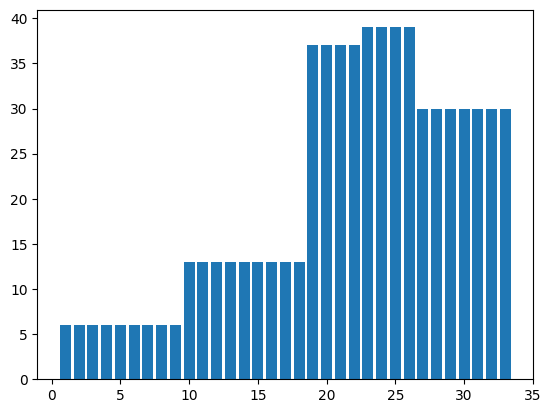

In [17]:
def plot():
    pm, tm = calc_pm(), calc_tm()

    work = np.append(pm * classic_coeffs[0], [1.08 * pm])
    time = np.append(tm * classic_coeffs[1], [1.36 * tm])
    
    y = []
    for i in range(5):
        for _ in range(round(time[i])):
            y.append(round(work[i] / time[i]))

    x = [i + 1 for i in range(len(y))]

    plt.bar(x, y)
    plt.show()

plot()

### Personal task 1

In [18]:
SIZE = 100

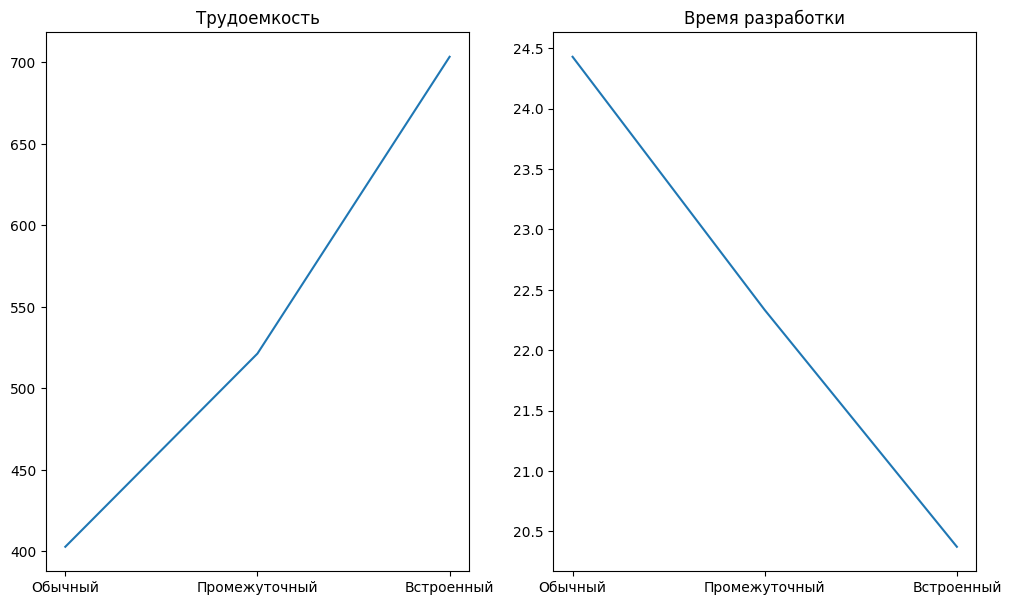

In [19]:
pms, tms = [], []
for i in range(len(project_modes["c1"])):
    pms += [PM(project_modes["c1"][i], project_modes["p1"][i], 1, SIZE)]
    tms += [TM(project_modes["c2"][i], project_modes["p2"][i], pms[-1])]

x = [i for i in range(len(project_modes["c1"]))]
fig, axis = plt.subplots(1, 2, figsize=(12,7))

axis[0].set_title("Трудоемкость")
axis[0].set_xticks(x, project_types)
axis[0].plot(x, pms)

axis[1].set_title("Время разработки")
axis[1].set_xticks(x, project_types)
axis[1].plot(x, tms)

plt.show()

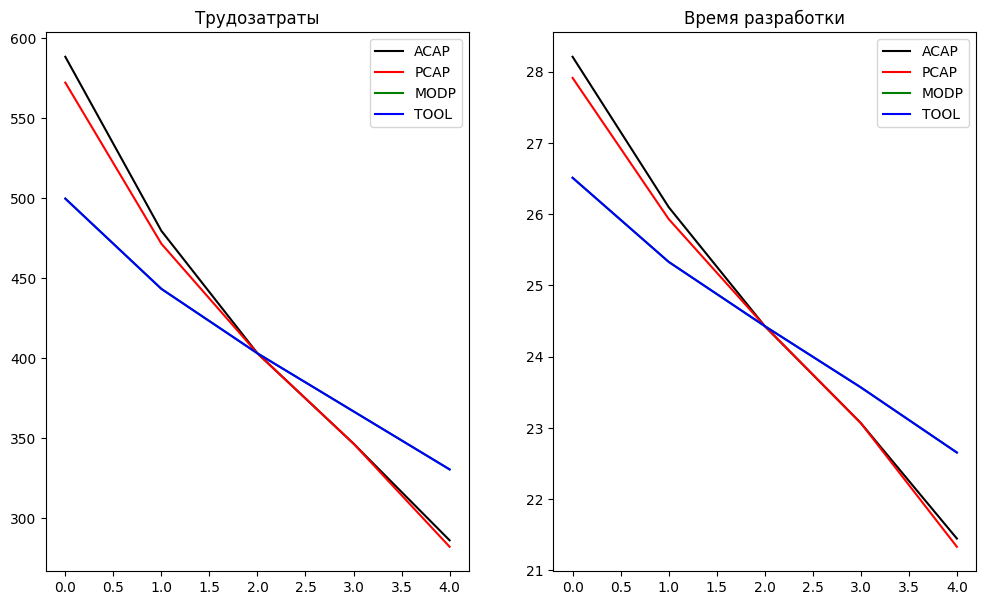

In [20]:
params = ["ACAP", "PCAP", "MODP", "TOOL"]

colors = ["k", "r", "g", "b"]

fig, axis = plt.subplots(1, 2, figsize=(12,7))

axis[0].set_title("Трудозатраты")
axis[1].set_title("Время разработки")

for i, p in enumerate(params):
    pms, tms = [], []
    for j, v in enumerate(params_table[p]):
        if v is None:
            continue
    
        pms += [PM(project_modes["c1"][0], project_modes["p1"][0], EAF(v), SIZE)]
        tms += [TM(project_modes["c2"][0], project_modes["p2"][0], pms[-1])]

    x = [j for j, v in enumerate(params_table[p]) if v is not None]
    axis[0].plot(x, pms, color=colors[i], label=p)
    axis[1].plot(x, tms, color=colors[i], label=p)

axis[0].legend()
axis[1].legend()
plt.show()